CUDA is not available. Using CPU.
Config: Hidden Sizes: (512, 256), Init: None, LR: 0.1, Accuracy: 97.65%
Config: Hidden Sizes: (512, 256), Init: None, LR: 0.01, Accuracy: 92.22%
Config: Hidden Sizes: (512, 256), Init: None, LR: 0.001, Accuracy: 66.68%
Config: Hidden Sizes: (512, 256), Init: xavier, LR: 0.1, Accuracy: 97.87%
Config: Hidden Sizes: (512, 256), Init: xavier, LR: 0.01, Accuracy: 93.15%
Config: Hidden Sizes: (512, 256), Init: xavier, LR: 0.001, Accuracy: 82.43%
Config: Hidden Sizes: (512, 256), Init: he, LR: 0.1, Accuracy: 97.81%
Config: Hidden Sizes: (512, 256), Init: he, LR: 0.01, Accuracy: 92.91%
Config: Hidden Sizes: (512, 256), Init: he, LR: 0.001, Accuracy: 80.25%
Config: Hidden Sizes: (512, 256), Init: manual, LR: 0.1, Accuracy: 97.82%
Config: Hidden Sizes: (512, 256), Init: manual, LR: 0.01, Accuracy: 92.86%
Config: Hidden Sizes: (512, 256), Init: manual, LR: 0.001, Accuracy: 82.58%
Config: Hidden Sizes: (1024, 512), Init: None, LR: 0.1, Accuracy: 97.52%
Config: Hid

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Config: Hidden Sizes: (2048, 1024), Init: manual, LR: 0.001, Accuracy: 85.77%


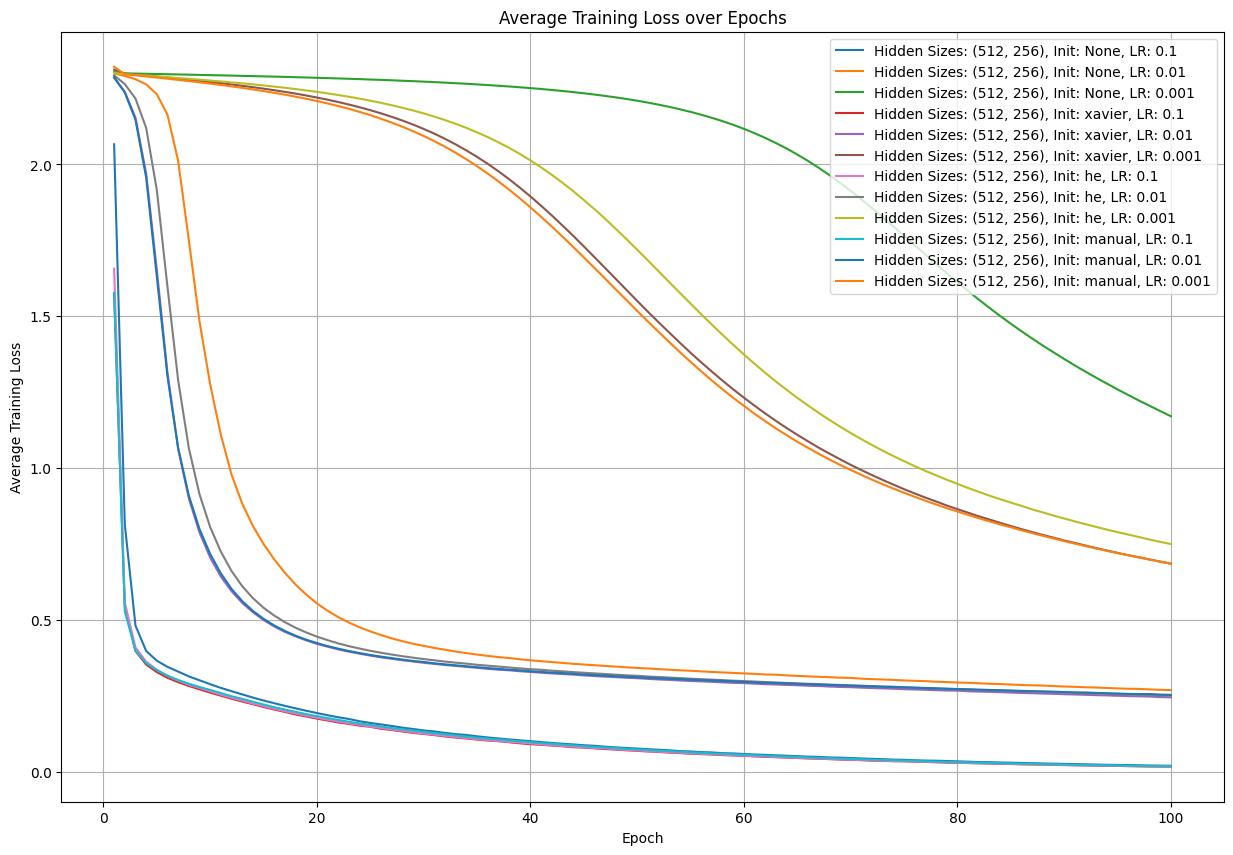

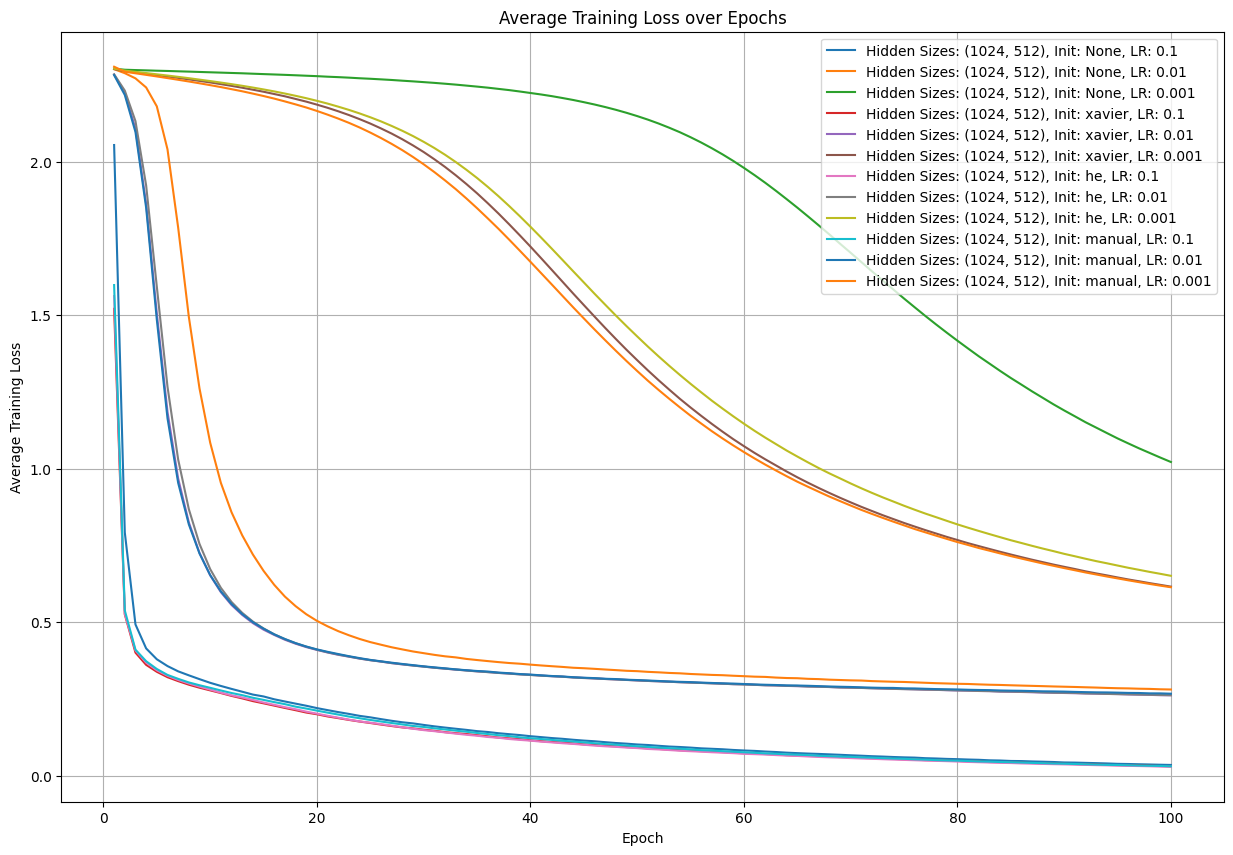

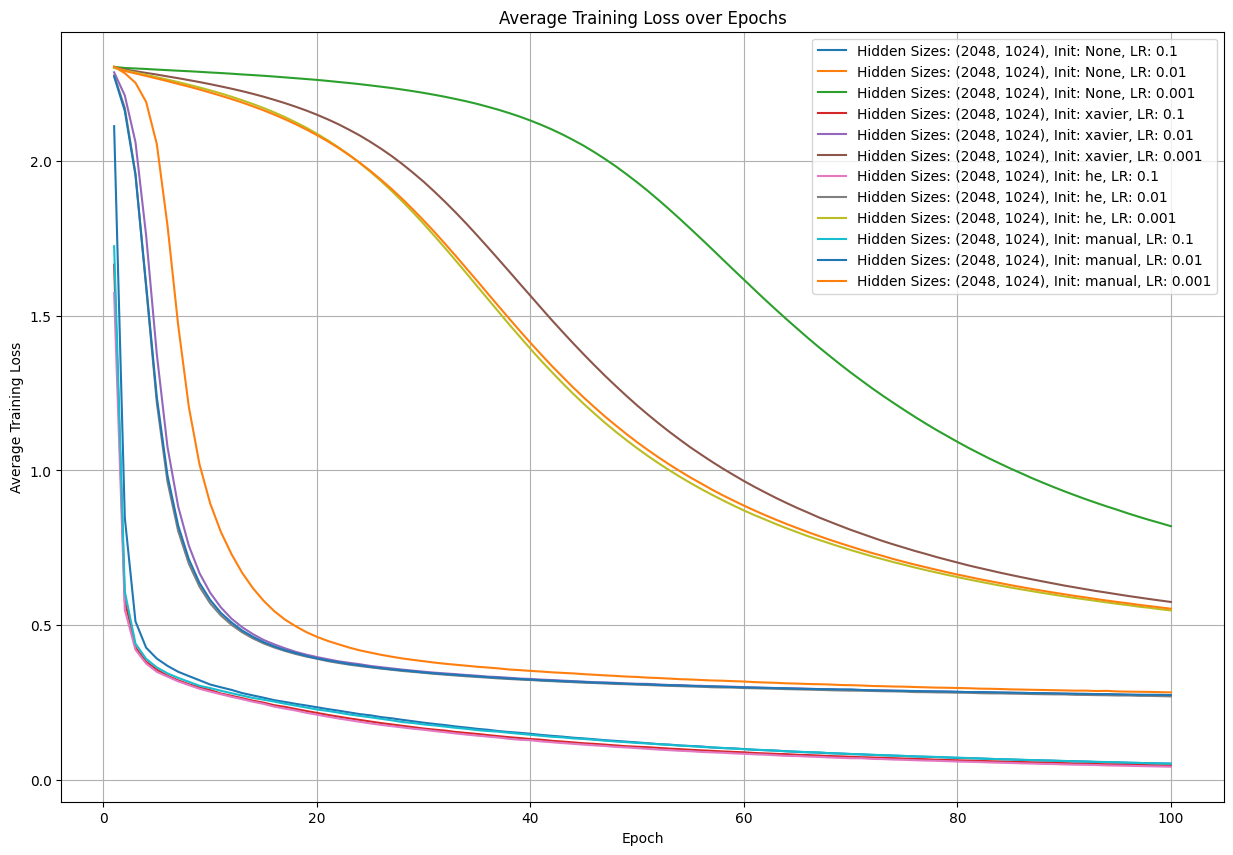

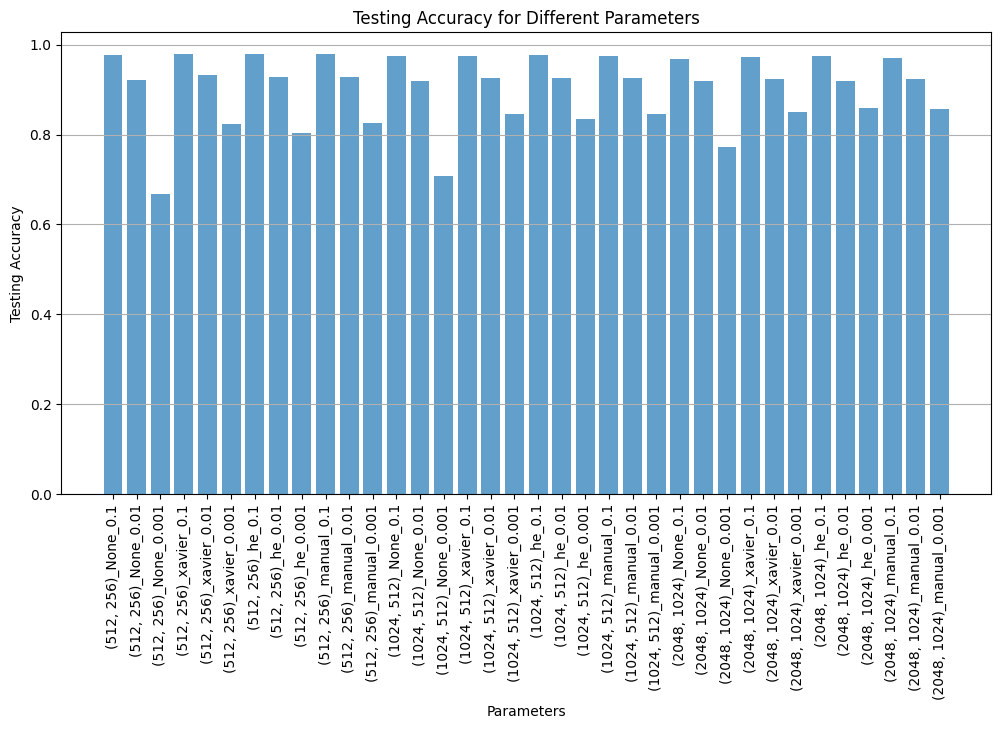

In [8]:
#%%
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import mnist_loader  
from torch.utils.data import Dataset, DataLoader


# Load data using load_data_wrapper
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

training_data = list(training_data)
validation_data = list(validation_data)
test_data = list(test_data)

class MNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_dataset = MNISTDataset(training_data)
validation_dataset = MNISTDataset(validation_data)
test_dataset = MNISTDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import math
import matplotlib.pyplot as plt
import numpy as np
# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes, init_method=None):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(784, hidden_sizes[0])
        self.hidden_layer_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output_layer = nn.Linear(hidden_sizes[1], 10)
        if init_method == "xavier":
            nn.init.xavier_uniform_(self.hidden_layer_1.weight)
            nn.init.xavier_uniform_(self.hidden_layer_2.weight)
        elif init_method == "he":
            nn.init.kaiming_uniform_(self.hidden_layer_1.weight, nonlinearity='sigmoid')
            nn.init.kaiming_uniform_(self.hidden_layer_2.weight, nonlinearity='sigmoid')
        elif init_method == "manual":
            self.initialize_weights(self.output_layer.weight)
            self.initialize_biases(self.output_layer.bias)
        

    def initialize_weights(self, tensor):
        # Custom weight initialization logic
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(tensor)
        
        bound = math.sqrt(6 / fan_in)   # bound = 1/sqrt(the number of weights) xvaier
#         bound = math.sqrt(1 / fan_in)  
        nn.init.uniform_(tensor, -bound, bound)  # initialization follows uniform distribution and is bounded by +-bound

    def initialize_biases(self, tensor):
        # Custom bias initialization logic
        nn.init.zeros_(tensor)

        

    def forward(self, x):
        x = torch.sigmoid(self.hidden_layer_1(x))
        x = torch.sigmoid(self.hidden_layer_2(x))
        x = self.output_layer(x)
        return torch.log_softmax(x, dim=1)

    
# Check if CUDA is available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("CUDA is available. Using GPU.")
# else:
#     device = torch.device("cpu")
#     print("CUDA is not available. Using CPU.")

device = torch.device("cpu")
print("CUDA is not available. Using CPU.")

# Initialize the model, loss function, and optimizer
def train_eval_model(hidden_sizes, init_method, lr):
    model = NeuralNetwork(hidden_sizes, init_method)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

# Train the neural network
    epochs = 100
    training_loss = []
    for epoch in range(epochs):

        model.train()
        train_correct = 0
        epoch_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.view(-1, 784))

            labels = torch.argmax(labels.view(labels.size(0), -1), dim=1)
#             labels = torch.argmax(labels.squeeze(), dim=1)


            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, id = torch.max(outputs.data, 1)
            train_correct += torch.sum(id == labels.data)
            epoch_loss += loss.item()
            
        average_loss = epoch_loss / len(train_loader) 
        training_accuracy = train_correct/len(train_dataset) 
        training_loss.append(average_loss)
#             print(f"Epoch {epoch+1}/{epochs}, Batch Loss: {loss.item()}")
            
    
    model.eval()
    test_correct = 0

    for inputs, labels in test_loader:
        inputs, lables = inputs.to(device), labels.to(device)
        outputs = model(inputs.view(-1, 784))
        _, id = torch.max(outputs.data, 1)
        test_correct += torch.sum(id == lables.data)
        
    accuracy = test_correct / len(test_dataset)
    print(f"Config: Hidden Sizes: {hidden_sizes}, Init: {init_method}, LR: {lr}, Accuracy: {accuracy * 100:.2f}%")
    return epochs, training_loss, training_accuracy, accuracy

def training_performance(results):
    plt.figure(figsize=(15, 10))

    for result in results:
        label = f"Hidden Sizes: {result['hidden_sizes']}, Init: {result['init_method']}, LR: {result['learning_rate']}"
        plt.plot(range(1, result['epochs'] + 1), result['training_loss'], label=label)

    plt.title('Average Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
def testing_performance(results):
    labels = [f"{result['hidden_sizes']}_{result['init_method']}_{result['learning_rate']}" for result in results]
    
    testing_accuracies = [result['testing_accuracy'] for result in results]

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(labels)), testing_accuracies, align='center', alpha=0.7)
    plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
    plt.xlabel('Parameters')
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy for Different Parameters')
    plt.grid(axis='y')
    plt.show()


hidden_sizes_configs = [(512, 256), (1024, 512), (2048, 1024)]
# hidden_sizes_configs = [(512, 256), (1024, 512)]
init_methods = [None, "xavier", "he", "manual"]
# init_methods = [None, "xavier"]
# learning_rates = [0.1, 0.01, 0.001]
# hidden_sizes_configs = [(1024, 512)]
# init_methods = [None]
learning_rates = [0.1, 0.01, 0.001]

results = []

for hidden_sizes in hidden_sizes_configs:
    for init_method in init_methods:
        for lr in learning_rates:
            [epochs, training_loss, training_accuracy, testing_accuracy]=train_eval_model(hidden_sizes, init_method, lr)
#             training_performance(epochs, training_loss)            
            results.append({
                'hidden_sizes': hidden_sizes,
                'init_method': init_method,
                'learning_rate': lr,
                'epochs': epochs,
                'training_loss': training_loss,
                'training_accuracy': training_accuracy,
                'testing_accuracy': testing_accuracy
            })
# plot the figures for different parameters 
# training_performance(results)

plt.figure(figsize=(15, 10))
for result in results:
    if result['hidden_sizes'] == (512, 256):
        label = f"Hidden Sizes: {result['hidden_sizes']}, Init: {result['init_method']}, LR: {result['learning_rate']}"
        plt.plot(range(1, result['epochs'] + 1), result['training_loss'], label=label)

    plt.title('Average Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.legend()
    plt.grid(True)
plt.figure(figsize=(15, 10))
for result in results:
    if result['hidden_sizes'] == (1024, 512):
        label = f"Hidden Sizes: {result['hidden_sizes']}, Init: {result['init_method']}, LR: {result['learning_rate']}"
        plt.plot(range(1, result['epochs'] + 1), result['training_loss'], label=label)

    plt.title('Average Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.legend()
    plt.grid(True)
plt.figure(figsize=(15, 10))
for result in results:
    if result['hidden_sizes'] == (2048, 1024):
        label = f"Hidden Sizes: {result['hidden_sizes']}, Init: {result['init_method']}, LR: {result['learning_rate']}"
        plt.plot(range(1, result['epochs'] + 1), result['training_loss'], label=label)

    plt.title('Average Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.legend()
    plt.grid(True)
testing_performance(results)


#%%

#%%
